<a href="https://colab.research.google.com/github/Yusbleidyk/House_Prices___Advanced_Regression_Techniques/blob/main/House_Prices___Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Precios de Casas - Técnicas Avanzadas de Regresión

Predice los precios de venta y practica ingeniería de características, bosques aleatorios (Random Forests) y gradient boosting.

## Descripción de la actividad

Este proyecto se basa en un conjunto de datos reales de casas en Ames, Iowa, que incluye 79 características diferentes de cada propiedad: desde el tipo de materiales usados hasta la cercanía a ciertas zonas. El reto consiste en predecir el precio final de venta de cada casa utilizando estas variables.

Es una excelente oportunidad para aplicar técnicas de ciencia de datos y machine learning, y descubrir cómo pequeños detalles pueden tener un gran impacto en el valor de una propiedad.

### Habilidades a practicar

Ingeniería creativa de características . Técnicas avanzadas de regresión como random forest y gradient boosting

### Objetivo:

 La tarea es predecir el precio de venta de cada casa. Para cada Id en el conjunto de prueba, se debe predecir el valor de la variable SalePrice.

### Métrica:


Las presentaciones se evalúan usando el error cuadrático medio de la raíz (RMSE) entre el logaritmo del valor predicho y el logaritmo del precio real. (Tomar logaritmos hace que los errores en casas caras y baratas afecten por igual el resultado).

## Importar librerías


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


## Cargar los Datos

In [47]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

## Exploración de Datos

In [48]:
print('='*100)
print('Estructura de los datos train')
print(train.info())
print('='*100)
print('Estadísticas datos train')
print(train.describe())
print('='*100)
print('Valores nulos datos train')
print(train.isnull().sum().sort_values(ascending=False).head(38))


Estructura de los datos train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 no

In [49]:
print('='*100)
#print('Estructura de los datos test')
print(test.info())
print('='*100)
print('Estadísticas de los datos test')
print(test.describe())
print('='*100)
#print('Valores nulos de los datos test')
print(test.isnull().sum().sort_values(ascending=False).head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

##  "Preprocesamiento de Datos" o "Data Wrangling".

### Manejo de valores faltantes

Las columnas con un número muy alto de valores nulos (más del 50%),  sugiere que la mayoría de las casas no poseen la caracteristica. Eliminar la columna es a menudo lo más práctico cuando la información es casi inexistente.

por lo tanto se eliminan las columnas

In [50]:
cols_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature','MasVnrType','FireplaceQu']
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)

In [51]:

# Separar columnas numéricas y categóricas
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# Eliminar 'SalePrice' de num_cols para no modificarla
num_cols.remove('SalePrice')

se implementa una estrategia de imputación simple: se rellena los valores faltantes en las columnas numéricas con la mediana y los valores faltantes en las columnas categóricas con la moda.

In [52]:
# Imputar valores faltantes
for col in num_cols:
  train[col].fillna(train[col].median(), inplace=True)
  test[col].fillna(test[col].median(), inplace=True)

for col in cat_cols:
  train[col].fillna(train[col].mode()[0], inplace=True)
  test[col].fillna(test[col].mode()[0], inplace=True)

/tmp/ipython-input-52-3191467789.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].median(), inplace=True)
/tmp/ipython-input-52-3191467789.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [53]:
print('Valores nulos de los datos train')
print(train.isnull().sum().sort_values(ascending=False).head(20))
print(train.info())

Valores nulos de los datos train
Id              0
MSSubClass      0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9 

In [54]:
print('Valores nulos de los datos test')
print(test.isnull().sum().sort_values(ascending=False).head(20))
print(test.info())

Valores nulos de los datos test
Id              0
MSSubClass      0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9  

### Codificar variables categóricas

In [55]:
# aplicar la técnica de One-Hot Encoding a las variables categóricas
train = pd.get_dummies(train).astype(int)
test = pd.get_dummies(test).astype(int)

### Crear un nuevo  dataset sin la variable objetivo (Target Variable)

In [56]:
# Aplicamos la transformación logarítmica directamente a la columna 'SalePrice' en el DataFrame train
train['SalePrice'] = np.log(train['SalePrice'])

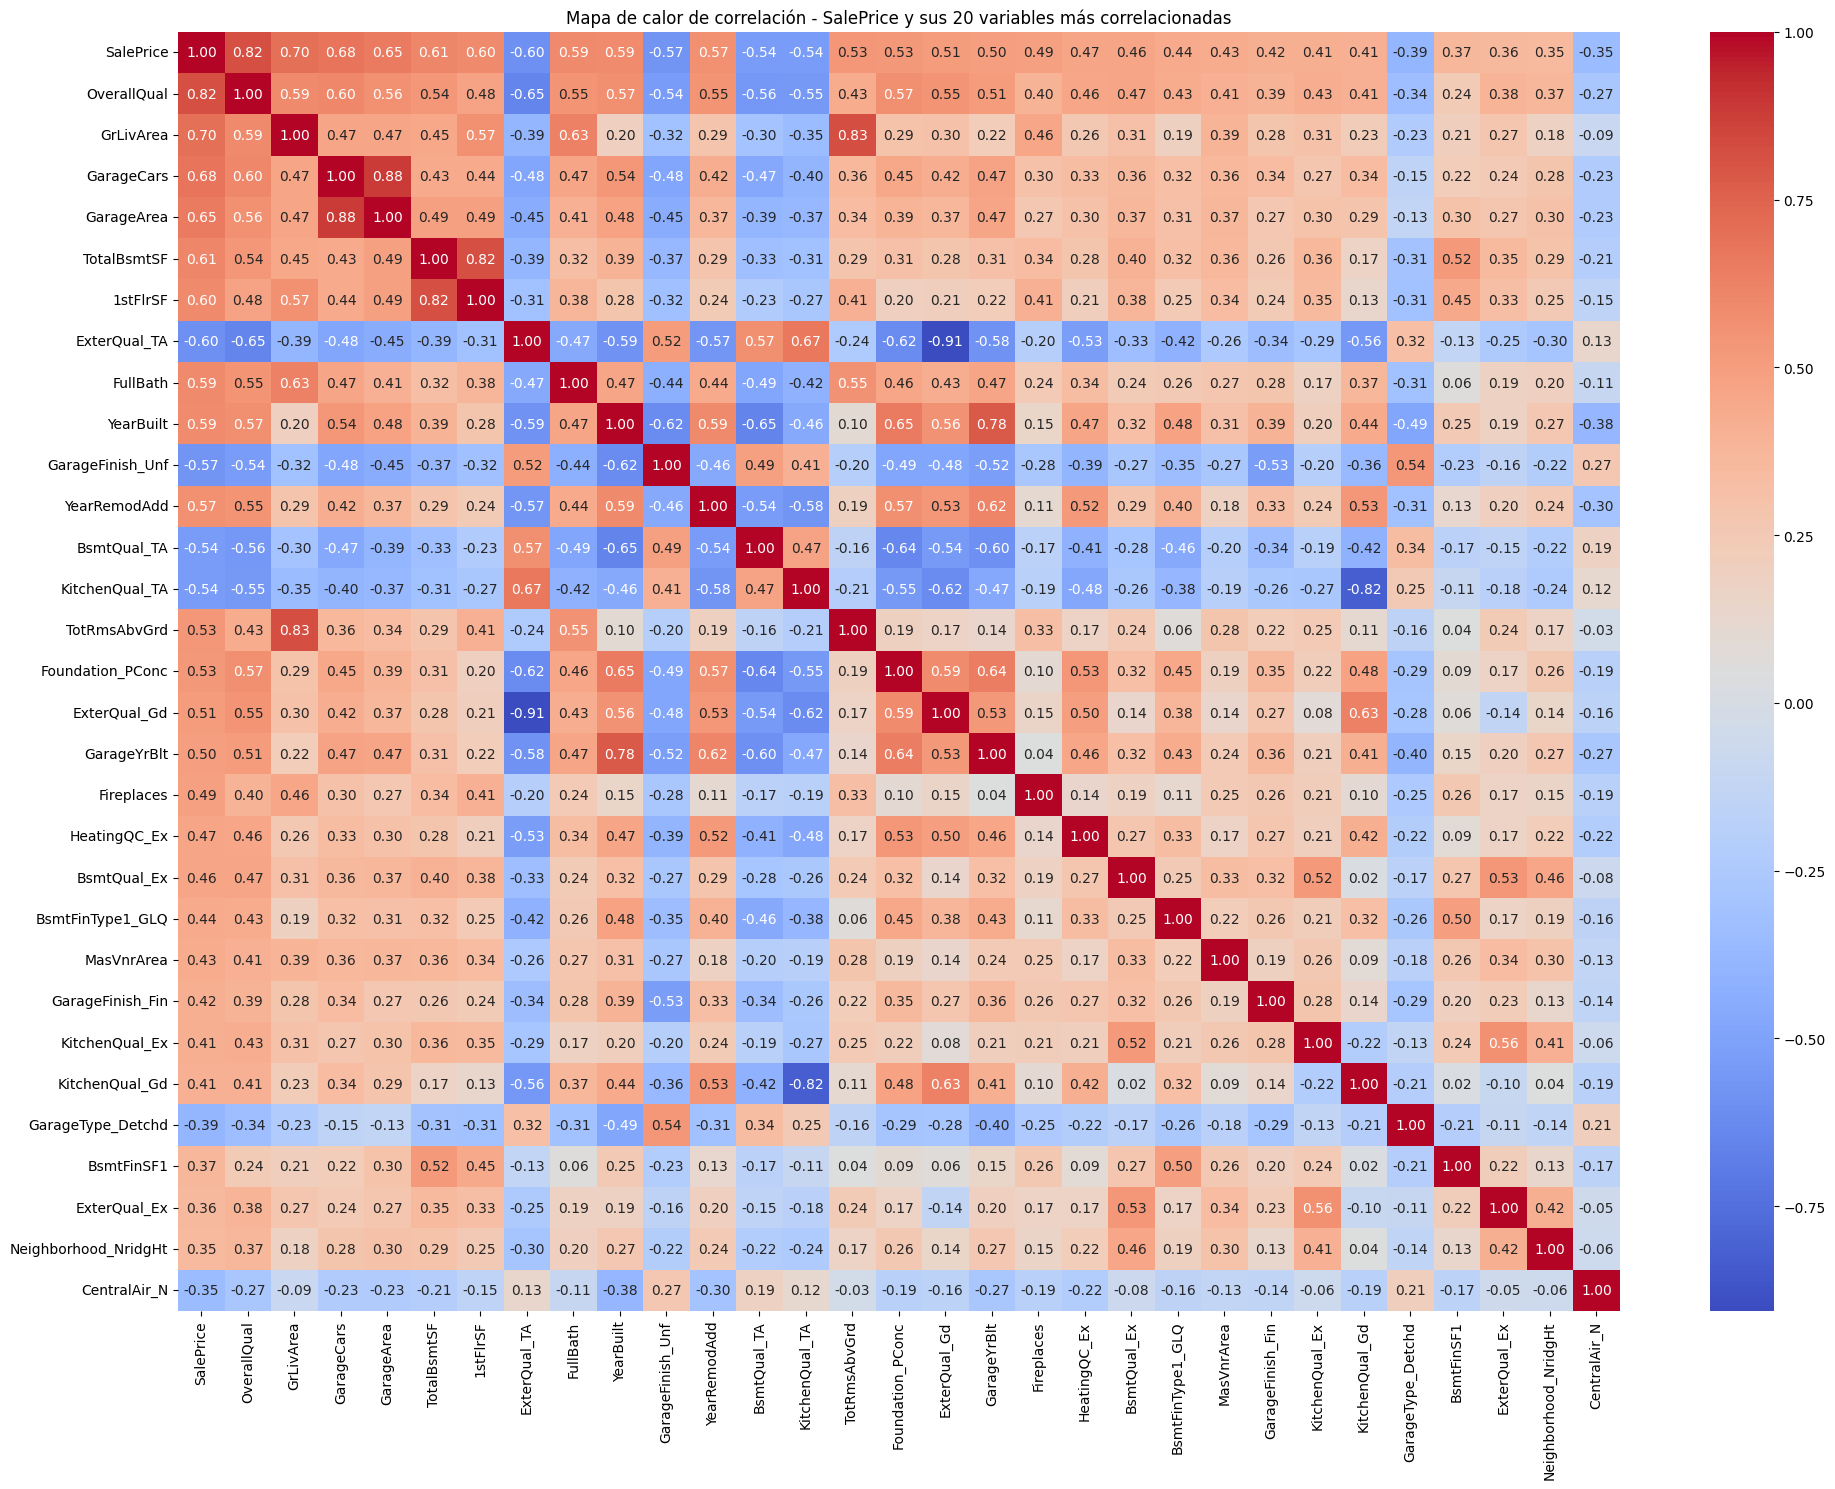

In [57]:
# Calcular la matriz de correlación
correlation_matrix = train.corr()

# Seleccionar las 20 variables más correlacionadas con SalePrice (absoluto)
top_corr_features = correlation_matrix['SalePrice'].abs().sort_values(ascending=False).index[1:31]

# Incluir SalePrice en la lista para el mapa de calor
selected_features = ['SalePrice'] + list(top_corr_features)

# Crear el mapa de calor
plt.figure(figsize=(20, 15))
sns.heatmap(train[selected_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de calor de correlación - SalePrice y sus 20 variables más correlacionadas")
plt.tight_layout()
plt.show()



In [58]:
# Mostrar las 15 variables más correlacionadas
top_corr_features = correlation_matrix['SalePrice'].abs().sort_values(ascending=False).index[1:31]
print("Variables más correlacionadas con SalePrice:")
print(top_corr_features.tolist())


Variables más correlacionadas con SalePrice:
['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'ExterQual_TA', 'FullBath', 'YearBuilt', 'GarageFinish_Unf', 'YearRemodAdd', 'BsmtQual_TA', 'KitchenQual_TA', 'TotRmsAbvGrd', 'Foundation_PConc', 'ExterQual_Gd', 'GarageYrBlt', 'Fireplaces', 'HeatingQC_Ex', 'BsmtQual_Ex', 'BsmtFinType1_GLQ', 'MasVnrArea', 'GarageFinish_Fin', 'KitchenQual_Ex', 'KitchenQual_Gd', 'GarageType_Detchd', 'BsmtFinSF1', 'ExterQual_Ex', 'Neighborhood_NridgHt', 'CentralAir_N']


In [59]:
selected_columns = list(top_corr_features)

In [60]:
train_features_rf = train.drop(columns=['SalePrice'])
train_target_rf = train['SalePrice']


### Dividimos el conjunto de entrenamiento para validación

In [61]:
#Para añadir replicabilidad usamos el random state
X_train, X_test, y_train, y_test = train_test_split(train_features_rf, train_target_rf, test_size=0.3, random_state=42)

### Alinear columnas entre train y test
Asegurar que ambos conjuntos contengan las mismas columnas, rellenando con ceros donde faltan

## Entrenar el Modelo

### Modelo Random Forest

In [62]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 0.13827365257295646


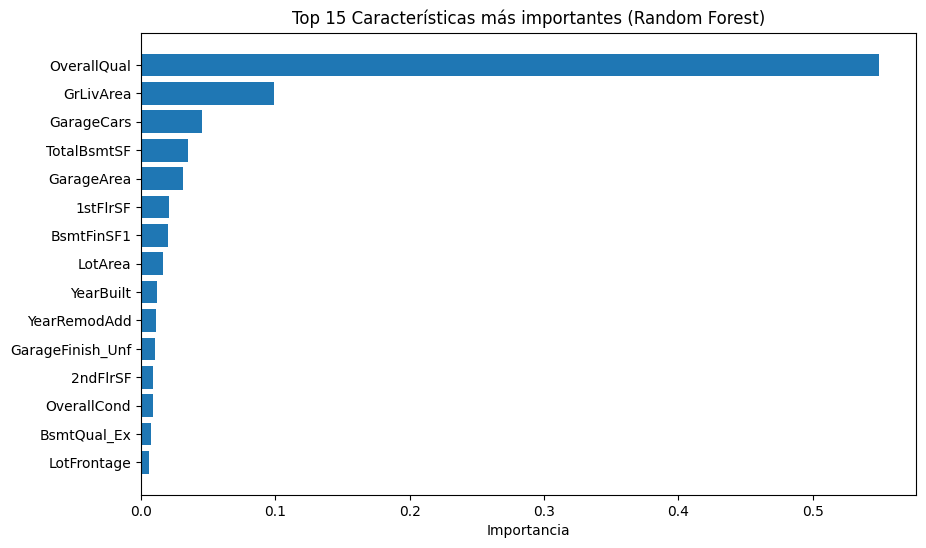

In [63]:
importances = rf.feature_importances_
features = train_features_rf.columns

# Crear un DataFrame con las características y sus importancias
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.title('Top 15 Características más importantes (Random Forest)')
plt.xlabel('Importancia')
plt.show()


In [64]:
# Extraer la lista de características ordenadas
ordered_features = importance_df['Feature'].tolist()
print(ordered_features)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'BsmtFinSF1', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'GarageFinish_Unf', '2ndFlrSF', 'OverallCond', 'BsmtQual_Ex', 'LotFrontage', 'GarageType_Detchd', 'OpenPorchSF', 'Fireplaces', 'BsmtUnfSF', 'Id', 'GarageYrBlt', 'CentralAir_Y', 'CentralAir_N', 'MoSold', 'WoodDeckSF', 'MSZoning_RM', 'TotRmsAbvGrd', 'MasVnrArea', 'KitchenAbvGr', 'HeatingQC_Fa', 'GarageType_Attchd', 'YrSold', 'BedroomAbvGr', 'LotShape_Reg', 'MSSubClass', 'MSZoning_RL', 'BsmtQual_Gd', 'BsmtFullBath', 'FullBath', 'KitchenQual_TA', 'ScreenPorch', 'Electrical_SBrkr', 'BsmtExposure_No', 'SaleCondition_Abnorml', 'BldgType_1Fam', 'LandContour_Bnk', 'Functional_Typ', 'ExterCond_TA', 'PavedDrive_N', 'BsmtExposure_Gd', 'EnclosedPorch', 'Exterior1st_VinylSd', 'BsmtFinType1_Unf', 'Neighborhood_OldTown', 'ExterCond_Fa', 'SaleCondition_Family', 'BsmtFinType1_GLQ', 'Exterior2nd_VinylSd', 'SaleCondition_Normal', 'HeatingQC_TA', 'KitchenQual_Gd', 'Found

### Reentrenar modelo con características mas importantes

In [65]:
top_15_features = ordered_features[:15]
train_features_top_15 = train_features_rf[top_15_features]
train_target = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(train_features_top_15, train_target, test_size=0.3, random_state=42)

In [66]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
rf_preds = model_rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 0.13776369364392052


In [67]:
# Guardar la columna Id
test_ids = test['Id']

# Eliminar la columna Id antes de alinear
test = test.drop(columns=['Id'])

# Alinear columnas con X_train
X_train, test = X_train.align(test, join='left', axis=1, fill_value=0)



#### Implementacion de cross_validation para modelo Random Forest

In [68]:
from sklearn.model_selection import (
    cross_val_score, KFold
)

In [69]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

score = cross_val_score(model_rf, X_train, y_train, cv= kf, scoring='neg_mean_squared_error')
print(np.abs(np.mean(score)))

# Convertimos los scores a positivos
rmse_scores = -score

# Mostramos estadísticas
print("RMSE por fold:", rmse_scores)
print("Promedio RMSE:", rmse_scores.mean())
print("Desviación estándar RMSE:", rmse_scores.std())

cv = rmse_scores.std() / rmse_scores.mean()
print("Coeficiente de variación:", cv)


0.023688982132831406
RMSE por fold: [0.02132612 0.02163075 0.02811008]
Promedio RMSE: 0.023688982132831406
Desviación estándar RMSE: 0.003128658158689173
Coeficiente de variación: 0.13207229171544071


### predicciones sobre el conjunto de prueba

In [70]:
rf_preds_test = model_rf.predict(test)
rf_preds_test = np.exp(rf_preds_test)

In [71]:
# Volver a agregar la columna Id
test['Id'] = test_ids

submission_rf = pd.DataFrame({
  'Id': test['Id'],
  'SalePrice': rf_preds_test
})

submission_rf.to_csv("submission_random_forest.csv", index=False)



### Modelo Gradient Boosting

#### Analizar valores outlier

Columna analizada: ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
Q1: SalePrice        11.775097
OverallQual       5.000000
GrLivArea      1129.500000
GarageCars        1.000000
TotalBsmtSF     795.750000
Name: 0.25, dtype: float64
Q3: SalePrice        12.273731
OverallQual       7.000000
GrLivArea      1776.750000
GarageCars        2.000000
TotalBsmtSF    1298.250000
Name: 0.75, dtype: float64
IQR: SalePrice        0.498634
OverallQual      2.000000
GrLivArea      647.250000
GarageCars       1.000000
TotalBsmtSF    502.500000
dtype: float64
Límite Inferior: SalePrice       11.027146
OverallQual      2.000000
GrLivArea      158.625000
GarageCars      -0.500000
TotalBsmtSF     42.000000
dtype: float64
Límite Superior: SalePrice        13.021682
OverallQual      10.000000
GrLivArea      2747.625000
GarageCars        3.500000
TotalBsmtSF    2052.000000
dtype: float64

Número de outliers identificados: 1460

Filas identificadas como outliers:


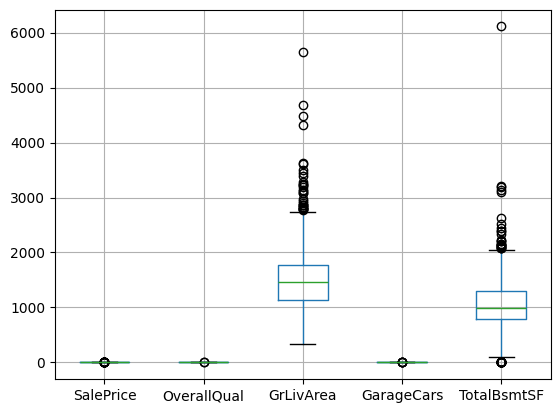

In [72]:
# Seleccionar la columna para analizar outliers
col_to_analyze = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']

# Calcular Q1, Q3 e IQR
Q1 = train[col_to_analyze].quantile(0.25)
Q3 = train[col_to_analyze].quantile(0.75)
IQR = Q3 - Q1

# Calcular los límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers
outliers = train[(train[col_to_analyze] < lower_bound) | (train[col_to_analyze] > upper_bound)]

print(f"Columna analizada: {col_to_analyze}")
print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Límite Inferior: {lower_bound}")
print(f"Límite Superior: {upper_bound}")
print(f"\nNúmero de outliers identificados: {len(outliers)}")
print("\nFilas identificadas como outliers:")
train.boxplot(column=col_to_analyze)
plt.show()

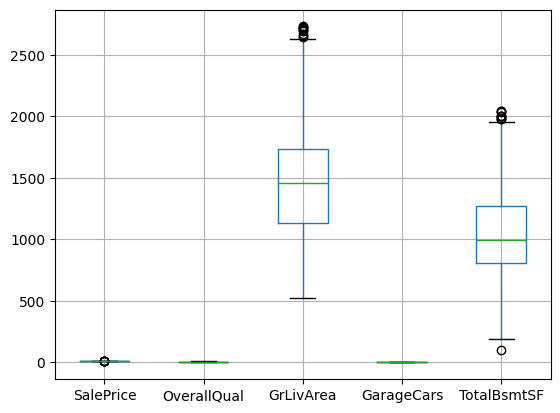

In [73]:
# Filtrar filas que no son outliers en ninguna de las columnas
Selection = ~((train[col_to_analyze] < lower_bound) | (train[col_to_analyze] > upper_bound)).any(axis=1)
train_grb = train[Selection]
train_grb.boxplot(column=col_to_analyze)
plt.show()

In [74]:
train_features_grb = train_grb.drop(columns=['SalePrice'])
train_target_grb = train_grb['SalePrice']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(train_features_grb, train_target_grb, test_size=0.3, random_state=42)

In [76]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_preds))
print("Gradient Boosting RMSE:", gbr_rmse)

Gradient Boosting RMSE: 0.11802392012813175


#### Implementacion de cross_validation para modelo Gradient Boosting

In [77]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

score_2 = cross_val_score(gbr, X_train, y_train, cv= kf, scoring='neg_mean_squared_error')
print(np.abs(np.mean(score_2)))

# Convertimos los scores a positivos
rmse_scores_2 = -score_2

# Mostramos estadísticas
print("RMSE por fold:", rmse_scores_2)
print("Promedio RMSE:", rmse_scores_2.mean())
print("Desviación estándar RMSE:", rmse_scores_2.std())

cv_2 = rmse_scores_2.std() / rmse_scores_2.mean()
print("Coeficiente de variación:", cv_2)

0.013878496251583224
RMSE por fold: [0.01394061 0.01564869 0.01204619]
Promedio RMSE: 0.013878496251583224
Desviación estándar RMSE: 0.0014713722035150948
Coeficiente de variación: 0.10601812882625843


### Predicciones sobre el conjunto de prueba

In [78]:
X_train, test = X_train.align(test, join='left', axis=1, fill_value=0)

In [79]:
best_gbr_preds_test = gbr.predict(test)

In [80]:
best_gbr_preds_test = np.exp(rf_preds_test)

/tmp/ipython-input-80-719949202.py:1: RuntimeWarning: overflow encountered in exp
  best_gbr_preds_test = np.exp(rf_preds_test)


In [81]:
submission_gbr = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': rf_preds_test
})

submission_gbr.to_csv("submission_gradient_boosting.csv", index=False)


In [82]:
submission_gbr.head(5)

,Id,SalePrice
0,1461,127357.010618
1,1462,154846.448066
2,1463,186680.564736
3,1464,180863.441437
4,1465,198742.527888
